<a href="https://colab.research.google.com/github/gitnicolas343/Pruebas_Q_inspire_tuna_5/blob/main/fontera_de_decision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pennylane --quiet
import pennylane as qml
from pennylane import numpy as np
from pennylane import AdamOptimizer
import matplotlib.pyplot as plt
import numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 63.2 MB/s eta 0:00:00


In [ ]:
from scipy.stats import multivariate_normal as mn



def my_biclass_gm(mu1, Sigma1, mu2, Sigma2, scale=1.0, N1=100, N2=100):
    np.random.seed(0)
    Sigma1 = np.array(Sigma1) * scale
    Sigma2 = np.array(Sigma2) * scale

    pdf1 = mn(mu1, Sigma1)
    pdf2 = mn(mu2, Sigma2)

    X = np.r_[pdf1.rvs(size=N1), pdf2.rvs(size=N2)]
    y = np.array([0]*N1 + [1]*N2, dtype=int)  # Etiquetas 0 y 1 como enteros

    return X, y






In [ ]:

#definir medias y cov de las clases
mu1 = np.array([-3,-2])
mu2 = np.array([0,2])
Sigma1 = np.array([[2,0.8],[0.8,1]])
Sigma2 = np.array([[1.5,0.6],[0.6,3]])



In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def graficar_datos_2d(x, y, title="Datos 2D"):
    """
    Visualiza datos 2D con dos clases (0 y 1) usando colores distintos.
    """
    cmap = ListedColormap(['#FF5555', '#55FF55'])  # rojo para 0, verde para 1
    plt.figure(figsize=(6, 6))
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, edgecolor='k')
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.grid(True)
    plt.show()


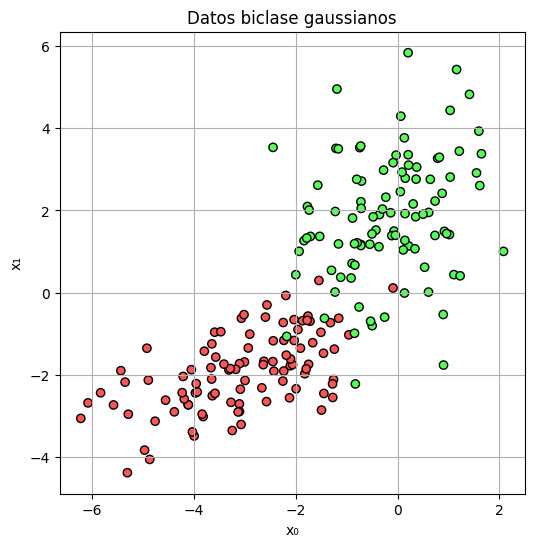

In [ ]:
X_gauss, y_gauss = my_biclass_gm(mu1,Sigma1,mu2,Sigma2, scale = 0.8, N1=100, N2=100)
graficar_datos_2d(X_gauss, y_gauss, title="Datos biclase gaussianos")


In [ ]:
def codificar(x, params):
    # combinación clásica de las entradas
    return params[0]*x[0] + params[1]*x[1] + params[2]

dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def dru_circuit(x_comb, p1, p2, p3):
    qml.RX(x_comb, wires=0)
    qml.RY(p1 * x_comb + p2, wires=0)
    qml.RZ(p3, wires=0)
    return qml.probs(wires=0)

def circuito_wrapper(params, x):
    x_comb = codificar(x, params)
    return dru_circuit(x_comb, params[3], params[4], params[5])


In [ ]:
#dev = qml.device("default.qubit", wires=1)
#@qml.qnode(dev)
#def dru_circuit(params, x):
#    # Codificación combinada no lineal de los inputs
#    x_comb = params[0] * x[0] + params[1] * x[1] + params[2]
#
#    qml.RX(x_comb, wires=0)
#    qml.RY(params[3] * x_comb + params[4], wires=0)
#    qml.RZ(params[5], wires=0)
#
#    return qml.probs(wires=0)


In [ ]:
# 4. Funciones de fidelidad, pérdida y exactitud
def fidelidad(params, x, y_target, funcion= circuito_wrapper):
    probs = funcion(params, x)
    return probs[y_target]

def loss(params, x_data, y_data):
    losses = [ (1 - fidelidad(params, x, y)) ** 2 for x, y in zip(x_data, y_data) ]
    return qml.numpy.mean(qml.numpy.stack(losses))


def exactitud(params, x_test, y_test):
    predicciones = [np.argmax(circuito_wrapper(params, x)) for x in x_test]
    return np.mean(predicciones == y_test)



In [ ]:
# 5. Minibatches
def iteracio_minibachtes(inputs, targets, batch_size):
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        end_idx = start_idx + batch_size
        yield inputs[start_idx:end_idx], targets[start_idx:end_idx]


In [ ]:
# 7. Configuración del entrenamiento
from sklearn.model_selection import train_test_split
np.random.seed(42)

epochs = 1000
batch_size = 10
learning_rate = 0.001

params = np.random.randn(6, requires_grad=True)
 # 3 parámetros libres

opt = AdamOptimizer(stepsize=learning_rate)

x, y =   my_biclass_gm(mu1,Sigma1,mu2,Sigma2, scale = 0.8, N1=100, N2=100)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

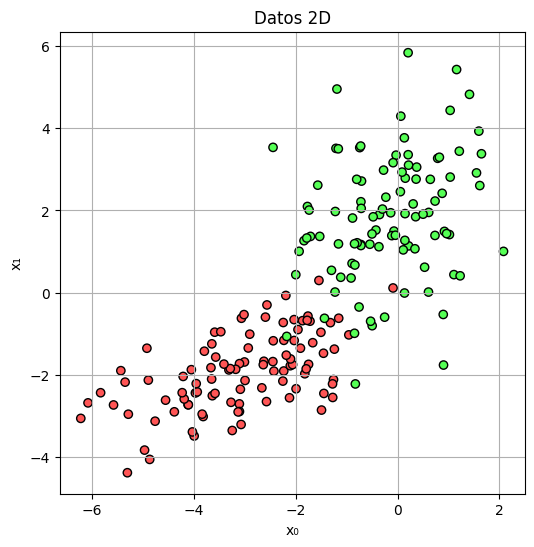

In [ ]:
graficar_datos_2d(x,y)

In [ ]:
for epoch in range(epochs):
    for x_batch, y_batch in iteracio_minibachtes(x_train, y_train, batch_size):
        params = opt.step(lambda p: loss(p, x_batch, y_batch), params)

    if (epoch + 1) % 50 == 0:
        l = loss(params, x_train, y_train)
        acc = exactitud(params, x_train, y_train)
        print(f"Época {epoch+1:2d}: Pérdida = {l:.4f} | Exactitud = {acc:.2%}")

Época 50: Pérdida = 0.0971 | Exactitud = 96.25%
Época 100: Pérdida = 0.0711 | Exactitud = 96.25%
Época 150: Pérdida = 0.0616 | Exactitud = 96.25%
Época 200: Pérdida = 0.0573 | Exactitud = 96.88%
Época 250: Pérdida = 0.0550 | Exactitud = 96.88%
Época 300: Pérdida = 0.0536 | Exactitud = 96.88%
Época 350: Pérdida = 0.0526 | Exactitud = 96.88%
Época 400: Pérdida = 0.0519 | Exactitud = 96.88%
Época 450: Pérdida = 0.0514 | Exactitud = 96.88%
Época 500: Pérdida = 0.0510 | Exactitud = 96.88%
Época 550: Pérdida = 0.0507 | Exactitud = 96.88%
Época 600: Pérdida = 0.0504 | Exactitud = 96.88%
Época 650: Pérdida = 0.0502 | Exactitud = 96.88%
Época 700: Pérdida = 0.0500 | Exactitud = 96.88%
Época 750: Pérdida = 0.0498 | Exactitud = 96.88%
Época 800: Pérdida = 0.0497 | Exactitud = 96.88%
Época 850: Pérdida = 0.0496 | Exactitud = 96.88%
Época 900: Pérdida = 0.0494 | Exactitud = 96.88%
Época 950: Pérdida = 0.0493 | Exactitud = 96.88%
Época 1000: Pérdida = 0.0493 | Exactitud = 96.88%


In [ ]:
params

tensor([ 0.06368833,  0.06568811,  0.17939192,  5.02329452,  1.20879312,
        -0.23413696], requires_grad=True)

In [ ]:
def graficar_frontera_cuantica(params, x, y, funcion_circuito, h=0.05, title="Frontera de decisión (cuántica)"):
    """
    Dibuja la frontera de decisión del clasificador cuántico.
    """
    from matplotlib.colors import ListedColormap
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

    # definir rejilla sobre espacio 2D
    x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
    y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # predicción cuántica para cada punto del mesh
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = [np.argmax(funcion_circuito(params, punto)) for punto in grid_points]
    Z = np.array(Z).reshape(xx.shape)

    # fondo coloreado según clase predicha
    plt.figure(figsize=(7,7))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)

    # puntos de entrenamiento originales
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel("x₀")
    plt.ylabel("x₁")
    plt.grid(True)
    plt.show()


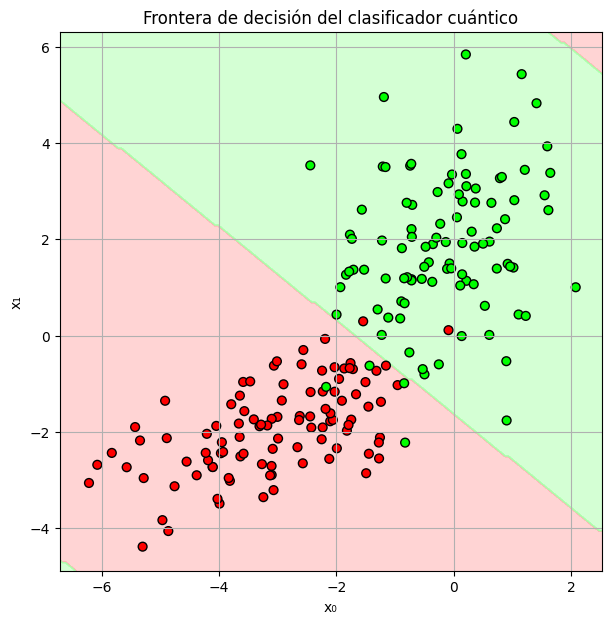

In [ ]:
graficar_frontera_cuantica(params,x ,y, funcion_circuito=circuito_wrapper,title="Frontera de decisión del clasificador cuántico")